In [1]:
import sys
sys.path.append('..')

import functools
import matplotlib.pyplot as plt
import numpy as np

import metrics
import utils

# One-Dimensional Kernel Smothers

## K neirest neighbours:

$$\hat{f}(x) = \frac{1}{K} \sum_{x_i \in N_K(x)} y_i$$

with $N_K(x)$ the $K$ closest points of $x$.

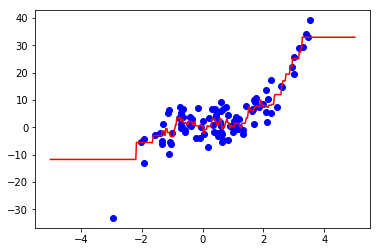

In [2]:
class MyKNN:
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def get_k_closest(self, x):
        
        dists = np.empty(len(self.X))
        for i in range(len(self.X)):
            dists[i] = (self.X[i] - x) @ (self.X[i] - x)
        
        p = dists.argsort()
        yp = self.y[p]
        return yp[:self.k]
        
        
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):    
            clos = self.get_k_closest(X[i])
            #print(clos.shape)
            y[i] = np.mean(clos)
        return y
            
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))


clf = MyKNN(k=5)
clf.fit(X,y)
preds = clf.predict(X)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

## Nadaraya-Watso kernel-weigthed average

$$\hat{f}(x_0) = \frac{\sum_{i=1}^N K(x_0, x_i)y_i}{\sum_{i=1}^N K(x_0, x_i)}$$


## Epanechnikov quadratic kernel

$$K_\lambda(x_0,x) = D(\frac{|x-x_0|}{\lambda})$$

with

$$D(t) = 
\begin{cases}
    \frac{3}{4}(1-t^2) & \text{if } |t| \leq 1\\
    0 & \text{otherwise}
\end{cases}
$$

$\lambda$ represent the with of the neighbourhood, it is constant.  
It can be made variables:

$$K_\lambda(x_0,x) = D(\frac{|x-x_0|}{h_\lambda(x_0)})$$

Large $\lambda$ implies lower variance but higher bias.

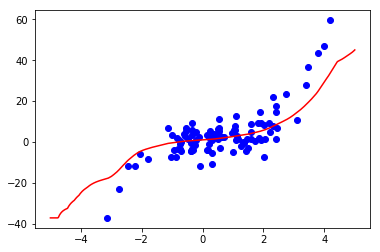

In [3]:


class NadarayaWatson:
    
    def __init__(self, kernel):
        self.kernel = kernel
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        
    def get_pred(self, x):
        num = 0
        den = 0
        for i in range(len(self.X)):
            d = self.kernel(x, self.X[i])
            num += d * self.y[i]
            den += d
        
        return 0 if den == 0 else num / den    
        
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
def epanechnikov(lbda, x0, x):
    t = np.linalg.norm(x - x0) / lbda
    if t <= 1:
        return 3/4 * (1-t**2)
    else:
        return 0
    

X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 2)
clf = NadarayaWatson(kernel)
clf.fit(X,y)
preds = clf.predict(X)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

# Local Linear Regression

Locally weighted regression solves a different weighted least squares problem at each target point $x_0$:

$$\min_{\alpha(x_0), \beta(x_0)} \sum_{i=1}^N K(x_0, x_i) [y_i - \alpha(x_0) - \beta(x_0)x_i]^2$$

The estimate is $\hat{f}(x_0) = \hat{\alpha}(x_0) + \hat{\beta}(x_0)x_0$

The estimate can be found by solving a weighted least square at the target point:

$$\hat{f}(x_0) = b(x_0)^T(B^TW(x_0)B)^{-1}B^TW(x_0)y$$

with:
- $b(x) \in \mathbb{R}^{p+1}$ the vector $x$ with an extra column $1$ at the beginning
- $B \in \mathbb{R}^{N*(p+1)}$ matrix where the i-th row is $b(x_i)$
- $W(x_0) \in \mathbb{R}^{N*N}$ diagonal matrix where $w_{ii} = K(x_0,x_i)$

The estimate is linear in $y_i$:
$$\hat{f}(x_0) = \sum_{i=1}^N l_i(x_0)y_i$$

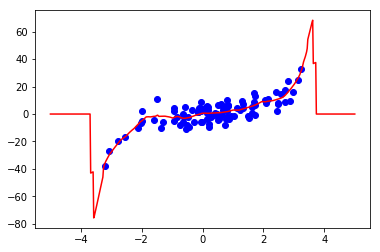

In [4]:
class LocallyWeightedRegression:
    
    def __init__(self, kernel):
        self.kernel = kernel
        
    def fit(self, X, y):
        self.X = X
        self.B = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        self.y = y
        
        
    def get_pred(self, x):
        b = np.ones(len(x) + 1)
        b[1:] = x
        
        
        W = np.zeros((len(self.X), len(self.X)))
        for i in range(len(self.X)):
            W[i,i] = self.kernel(x, self.X[i])
            
        BWB = self.B.T @ W @ self.B + 1e-6 * np.eye(len(b))
        beta = np.linalg.inv(BWB) @ self.B.T @ W @ y
        return b @ beta

        
    def predict(self, X):
        
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
    
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 0.5)
clf = LocallyWeightedRegression(kernel)
clf.fit(X,y)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500).reshape(-1, 1)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

## Local Polynomial Regression

We can fit local polynomials of any degree $d$:

$$\min_{\alpha(x_0), \beta_j(x_0), j=1,\text{...},d} \sum_{i=1}^N K(x_0, x_i) [y_i - \alpha(x_0) - \sum_{j=1}^d \beta_j(x_0)x_i^j]^2$$

It tend to recude bias of local regression, but also increase variance

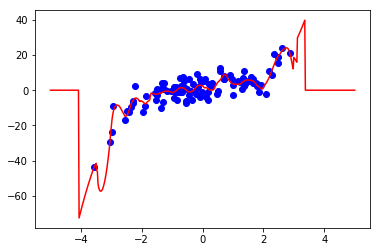

In [5]:
class LocallyPolynomialRegression:
    
    def __init__(self, kernel, degree):
        self.kernel = kernel
        self.d = degree
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.B = self.extend_x(self.X)
    
    def extend_x(self, X):
        n = X.shape[0]
        p = X.shape[1]
        B = np.empty((n, 1 + self.d*p))
        B[:, 0] = np.ones(n)
        
        for d in range(self.d):
            B[:, 1+p*d:1+p*d+p] = X**(d+1)
        return B
        
    
        
    def get_pred(self, x):
        b = self.extend_x(x.reshape(1, -1))[0]
        
        W = np.zeros((len(self.X), len(self.X)))
        for i in range(len(self.X)):
            W[i,i] = self.kernel(x, self.X[i])
            
        BWB = self.B.T @ W @ self.B + 1e-6 * np.eye(len(b))
        beta = np.linalg.inv(BWB) @ self.B.T @ W @ y
        return b @ beta

        
    def predict(self, X):
        
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
    
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 0.5)
clf = LocallyPolynomialRegression(kernel, degree=4)
clf.fit(X,y)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500).reshape(-1, 1)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

# Selecting the width of the kernel

$\lambda$ control the kernel width, might be different among kernels:
- Epanechnikov: $\lambda$ is the radius of the support region
- Gaussian: $\lambda$ is the standard deviation
- KNN: expressed as $k/n$, number of neighbors

With a small $\lambda$, the number of $y_i$ and smaller, which increase the variance,  and closer to $x_0$, which reduce the bias.  
With a high $\lambda$, there will be lots of $y_i$, and averaging reduces the variance, but the observations are farther from $x_i$, that increase the bias.

# Local Regression in $\mathbb{R}^p$

The same kernel techniques (KNN, local linear/polynomial regression) can be applied as $p$ increases.  
But one effect of the curse of dimensionality is that the fraction of points close to boundaries increase as the dimension grows, the kernel function should me modified to accomodate that.  

What's more, as $p$ increases, in order to both maintaint the localness (low bias) and a good number of neighbors (variance), the number of obervations must increase exponentially.

# Structured Local Regression in $\mathbb{R}^p$

## Structured Kernels

The default spheral kernel gives equal weight to each feature, a strategy could be to standardize the data. Another approch is to use a weight matrix to give different importance for the features:
$$K_{\lambda,A} = D( \frac{(x-x_0)^T A (x - x_0)}{\lambda})$$

with $A \in \mathbb{R}^{p*p}$ a positive semi-definite matrix of weights.  

If $A$ is diagonal, it's possible to control the influence of each feauture individually.  
Models can try to learn $A$, like the project-pursuit regression model.  
In general, models with $A$ are cumbersone, and they are better structurel models.

## Varying coefficient models

We divide $X$ into a set $(X_1, \text{...}, X_q)$ with $q < p$, and the reminding features are in $Z$.  

We define the linear model:
$$f(X) = \alpha(Z) + \sum_{i=1}^q \beta_i(Z)X_i$$

We can fit the model with locally weighted regression:

$$\min_{\alpha(z_0), \beta_j(z_0), j=1,\text{...},q} \sum_{i=1}^N K(z_0, z_i) [y_i - \alpha(z_0) - \sum_{j=1}^q x_{ij} \beta_j(z_0)]^2$$

# Local Likelihood and Other Models

We can extend log-likehilood by adding observations weights, computed locally with kernels:

$$l(\beta(x_0)) \sum_{i=1}^N K(x_0, x_i) l(y_i, x_i^T \beta(x_0))$$

We can extend the logistig regression model:

$$P(G=g|X=x) = \frac{\exp(\beta_g^Tx)}{1 + \sum_{k=1}^K \exp(\beta_k^Tx)}$$

The local likelihood can be written as:

$$\sum_{i=1}^N K(x_o,x_i) [\beta_g(x_0)^T(x_i - x_0) - \log (1 + \sum_{k=1}^K \exp(\beta_k(x_0)^T(x_i - x_0))  ]$$

The estimated probability is:

$$\hat{p} = P(G=g|X=x_0) = \frac{\exp(\hat{\beta}_j(x_0))}{1 + \sum_{k=1}^K \exp(\beta_k(x_0))}$$

# Kernel Density Estimation and Classification